In [1]:
#importando bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import prince
%matplotlib inline

# setting up plot style 
plt.style.use('fivethirtyeight')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)


In [2]:
#import dataset

df = pd.read_csv('../datasets/data_to_pca.csv')
#df.drop(columns = 'not_defined', inplace = True)
df.head()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,valor_frete_real,product_weight_g,product_photos_qty,payment_value,payment_installments
0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,4,8.72,500.0,4.0,38.71,1.0
1,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,4,22.76,400.0,1.0,141.46,1.0
2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,5,19.22,420.0,1.0,179.12,3.0
3,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,5,27.20,450.0,3.0,72.20,1.0
4,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,5,8.72,250.0,4.0,28.62,1.0


# Feature Engineering

## Date Columns

Add columns that are the difference between `order purchase` and anothers date columns

In [3]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])

In [4]:
df['diff_approved'] = df['order_approved_at'] - df['order_purchase_timestamp'] #diff data aprovação da compra - data da compra
df['diff_carrier'] = df['order_delivered_carrier_date'] - df['order_purchase_timestamp']
df['diff_customer'] = df['order_delivered_customer_date'] - df['order_purchase_timestamp']
df['diff_estimate'] = df['order_estimated_delivery_date'] - df['order_purchase_timestamp']
df['diff_est_del'] = df['order_estimated_delivery_date'] - df['order_delivered_customer_date']
df['diff_purchase_delivered'] = df['order_delivered_customer_date'] - df['order_purchase_timestamp']


#transforming the values in days difference
df['diff_approved']=df['diff_approved']/np.timedelta64(1,'D')
df['diff_carrier']=df['diff_carrier']/np.timedelta64(1,'D')
df['diff_customer']=df['diff_customer']/np.timedelta64(1,'D')
df['diff_estimate']=df['diff_estimate']/np.timedelta64(1,'D')
df['diff_est_del']=df['diff_est_del']/np.timedelta64(1,'D')
df['diff_purchase_delivered']=df['diff_purchase_delivered']/np.timedelta64(1,'D')

df.head()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,valor_frete_real,product_weight_g,product_photos_qty,payment_value,payment_installments,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,diff_purchase_delivered
0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,4,8.72,500.0,4.0,38.71,1.0,0.007431,2.373924,8.436574,15.544063,7.107488,8.436574
1,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,4,22.76,400.0,1.0,141.46,1.0,1.279745,1.742627,13.782037,19.137766,5.355729,13.782037
2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,5,19.22,420.0,1.0,179.12,3.0,0.011505,0.216100,9.394213,26.639711,17.245498,9.394213
3,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,5,27.20,450.0,3.0,72.20,1.0,0.012419,3.758252,13.208750,26.188819,12.980069,13.208750
4,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,5,8.72,250.0,4.0,28.62,1.0,0.042940,0.936053,2.873877,12.112049,9.238171,2.873877


In [5]:
#drop date columns
cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
        'order_delivered_customer_date', 'order_estimated_delivery_date']

df.drop(columns = cols, axis= 1, inplace = True)
df.head()

,review_score,valor_frete_real,product_weight_g,product_photos_qty,payment_value,payment_installments,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,diff_purchase_delivered
0,4,8.72,500.0,4.0,38.71,1.0,0.007431,2.373924,8.436574,15.544063,7.107488,8.436574
1,4,22.76,400.0,1.0,141.46,1.0,1.279745,1.742627,13.782037,19.137766,5.355729,13.782037
2,5,19.22,420.0,1.0,179.12,3.0,0.011505,0.216100,9.394213,26.639711,17.245498,9.394213
3,5,27.20,450.0,3.0,72.20,1.0,0.012419,3.758252,13.208750,26.188819,12.980069,13.208750
4,5,8.72,250.0,4.0,28.62,1.0,0.042940,0.936053,2.873877,12.112049,9.238171,2.873877


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96454 entries, 0 to 96453
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   review_score             96454 non-null  int64  
 1   valor_frete_real         96454 non-null  float64
 2   product_weight_g         96454 non-null  float64
 3   product_photos_qty       96454 non-null  float64
 4   payment_value            96454 non-null  float64
 5   payment_installments     96454 non-null  float64
 6   diff_approved            96454 non-null  float64
 7   diff_carrier             96454 non-null  float64
 8   diff_customer            96454 non-null  float64
 9   diff_estimate            96454 non-null  float64
 10  diff_est_del             96454 non-null  float64
 11  diff_purchase_delivered  96454 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 8.8 MB


# Model

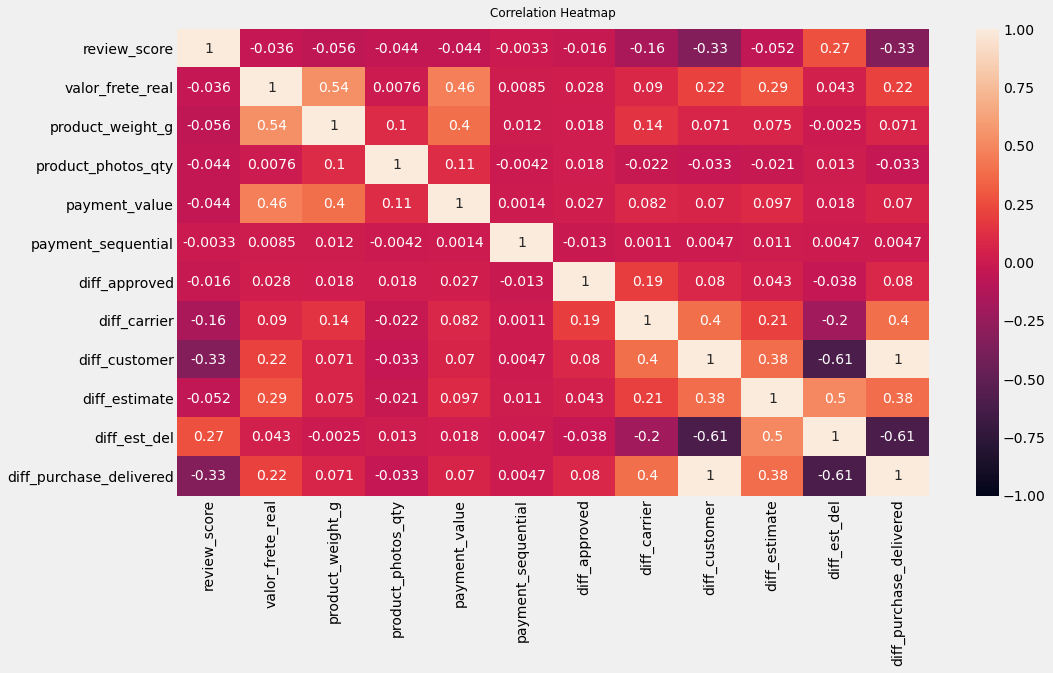

In [22]:
plt.figure(figsize = (15,8))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

In [23]:
scaler = StandardScaler()

Xs = scaler.fit_transform(df)
#X = df.loc[:,:]
Xs

array([[-0.11174863, -0.728517  , -0.39547969, ..., -0.93499198,
        -0.3996738 , -0.43171035],
       [-0.11174863,  0.16644267, -0.41644509, ..., -0.52474933,
        -0.57170496,  0.12831648],
       [ 0.66057886, -0.05920955, -0.41225201, ...,  0.33164226,
         0.59592735, -0.33138163],
       ...,
       [ 0.66057886,  2.86024579,  2.28809142, ...,  0.75910079,
        -0.55510108,  1.28885812],
       [-1.6564036 ,  1.30299046,  2.24616062, ...,  1.52634504,
         0.86828086,  0.47450635],
       [ 0.66057886, -0.11402902, -0.46885859, ...,  0.15892722,
         0.61624915, -0.51157075]])

### Elbow Curve

In [24]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42}
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(Xs)
    sse.append(kmeans.inertia_)


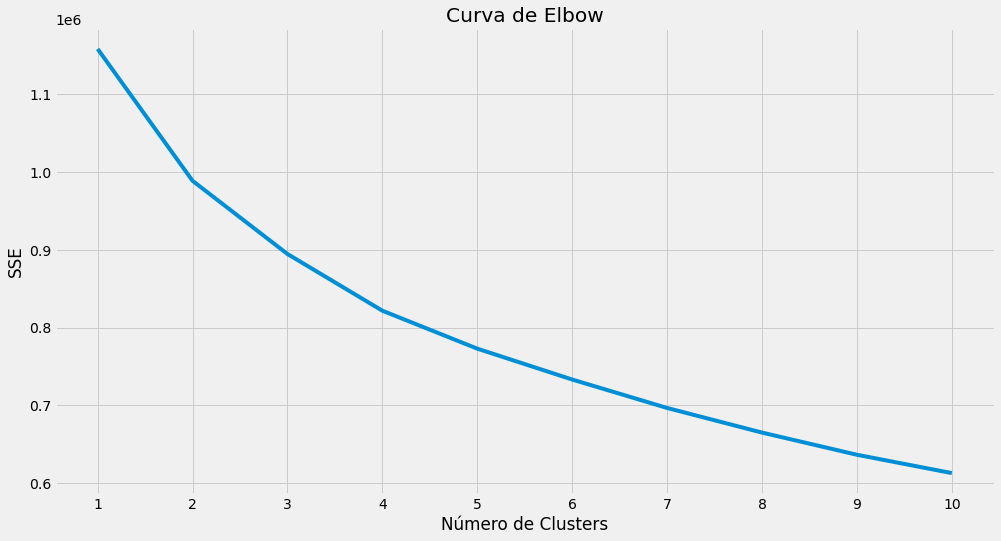

In [26]:
plt.figure(figsize = (15,8))

plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Número de Clusters")
plt.title('Curva de Elbow')
plt.ylabel("SSE")
plt.show()

In [27]:
kmeans = KMeans(n_clusters=5,
                init='random',
                n_init = 10,
                max_iter = 300,
                random_state = 42)
kmeans.fit(Xs)
y_kmeans = kmeans.predict(Xs)


In [28]:
df_cluster = df.copy()
df_cluster['cluster'] = y_kmeans
df_cluster.head()

,review_score,valor_frete_real,product_weight_g,product_photos_qty,payment_value,payment_sequential,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,diff_purchase_delivered,cluster
0,4,8.72,500.0,4.0,38.71,3.0,0.007431,2.373924,8.436574,15.544063,7.107488,8.436574,4
1,4,22.76,400.0,1.0,141.46,1.0,1.279745,1.742627,13.782037,19.137766,5.355729,13.782037,1
2,5,19.22,420.0,1.0,179.12,1.0,0.011505,0.216100,9.394213,26.639711,17.245498,9.394213,2
3,5,27.20,450.0,3.0,72.20,1.0,0.012419,3.758252,13.208750,26.188819,12.980069,13.208750,2
4,5,8.72,250.0,4.0,28.62,1.0,0.042940,0.936053,2.873877,12.112049,9.238171,2.873877,4


In [30]:
df_cluster['cluster'].value_counts()

4    44120
2    31419
1     9145
3     7593
0     4177
Name: cluster, dtype: int64

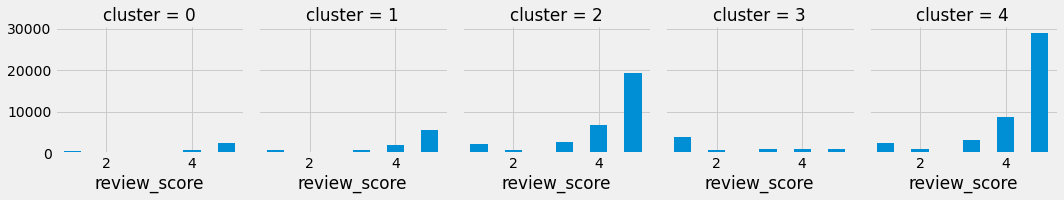

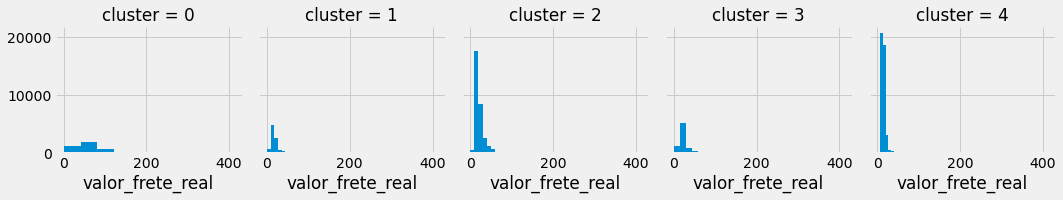

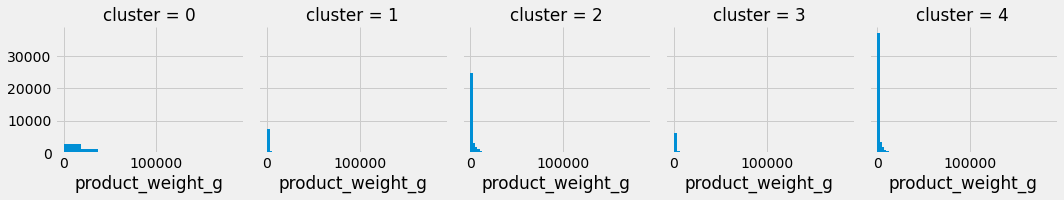

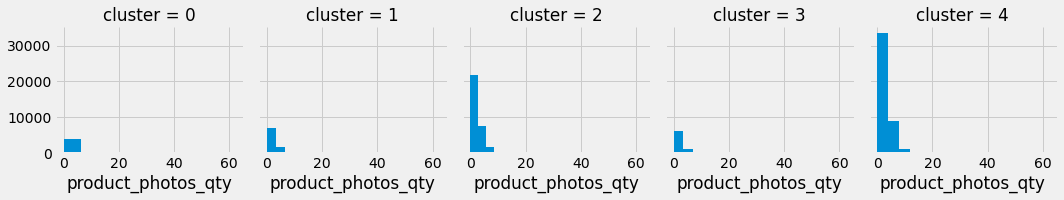

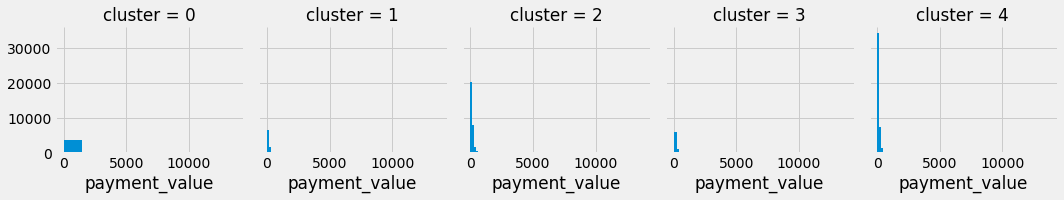

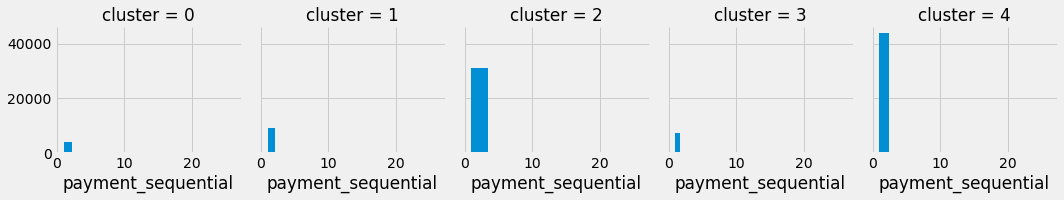

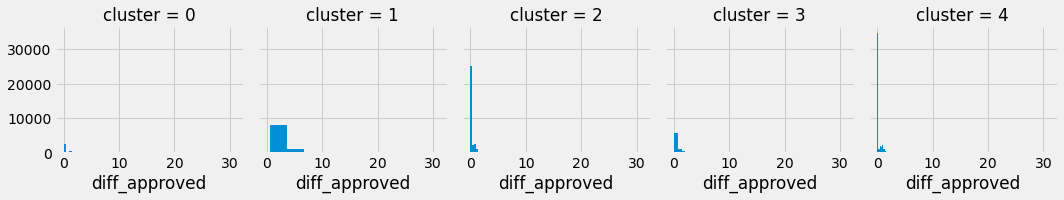

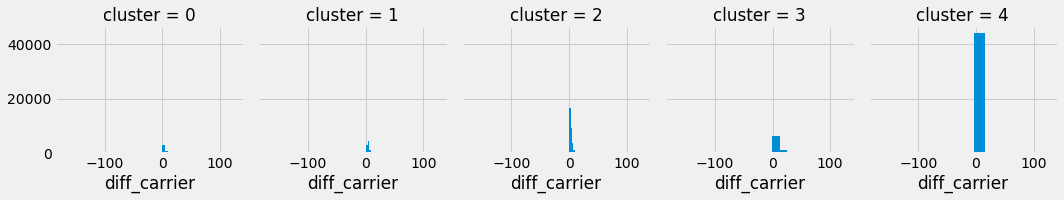

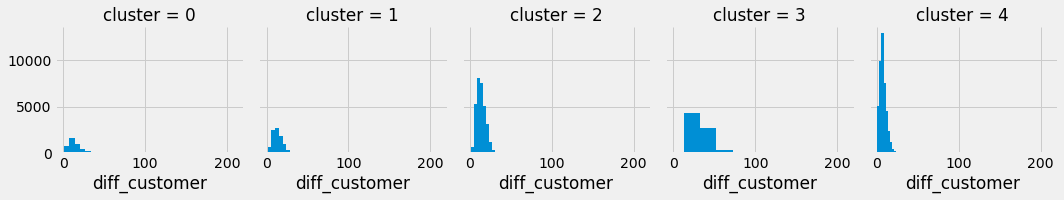

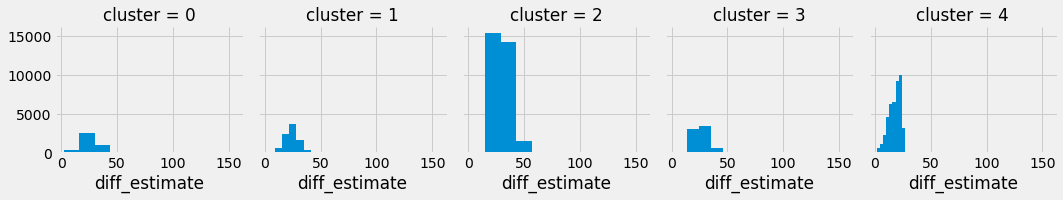

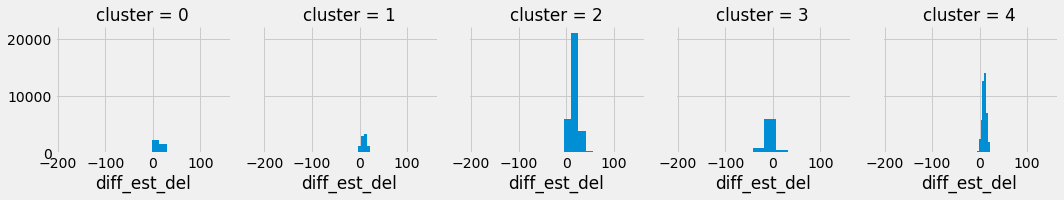

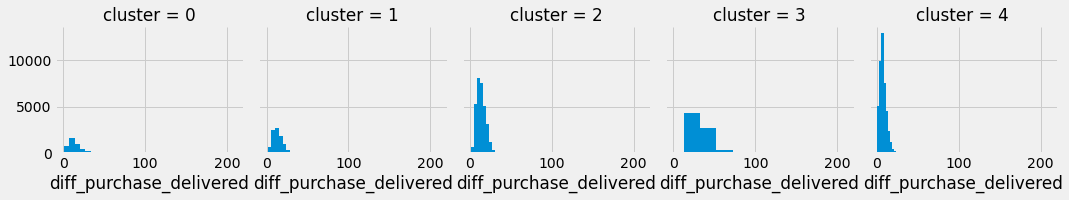

In [29]:
for c in df:
    grid = sns.FacetGrid(df_cluster, col='cluster')
    grid.map(plt.hist, c)

------------------------------------

## Applying PCA

In [43]:
pca = prince.PCA(
    n_components=2,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42
)
pca = pca.fit(Xs)

In [44]:
pca.transform(Xs).head()

,0,1
0,-0.902692,-0.999305
1,0.163935,-0.654124
2,-1.028104,0.263374
3,-0.117535,0.096886
4,-2.040524,-0.886934


No handles with labels found to put in legend.


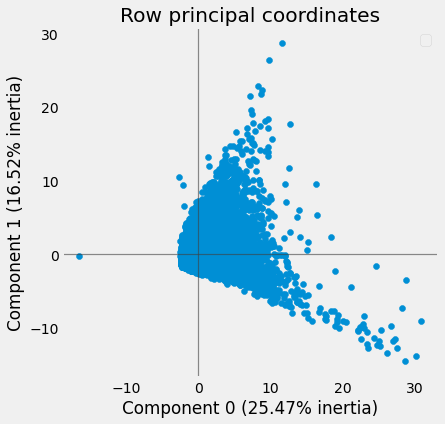

In [45]:
ax = pca.plot_row_coordinates(
    Xs,
    ax=None,
    figsize=(6, 6),
    x_component=0,
    y_component=1,
    labels=None,
    ellipse_outline=False,
    ellipse_fill=True,
    show_points=True
)

In [46]:
# applying PCA in dataset

pca = PCA(n_components=min(Xs.shape[0],Xs.shape[1]))
d=pca.fit_transform(Xs)

In [47]:
scree = pca.explained_variance_ratio_
nbr_pca=0
N=110
for i in range(N):
    a = scree.cumsum()[i]
    if a >= 0.80:
        print("{} principal components explain at least 80% of the total variance".format(i))
        print("Exact value of variance explained: {}%".format(round(a*100,2)))
        nbr_pca=i
        break
pca = PCA(n_components=nbr_pca)
d=pca.fit_transform(Xs)

6 principal components explain at least 80% of the total variance
Exact value of variance explained: 85.7%


In [48]:
data_pca=pd.DataFrame(d)
col=["pca "+ str(n+1) for n in data_pca.columns]
data_pca.columns=col
data_pca.head()

,pca 1,pca 2,pca 3,pca 4,pca 5,pca 6
0,-0.902692,-0.999305,0.696968,-1.352668,5.051642,1.114825
1,0.163935,-0.654124,0.286152,0.518553,0.068518,-0.816772
2,-1.028104,0.263374,-0.612764,-0.732523,-0.286313,-0.482193
3,-0.117535,0.096886,-0.481272,-0.310672,-0.222345,0.084626
4,-2.040524,-0.886934,0.993306,0.056125,-0.110463,0.363178


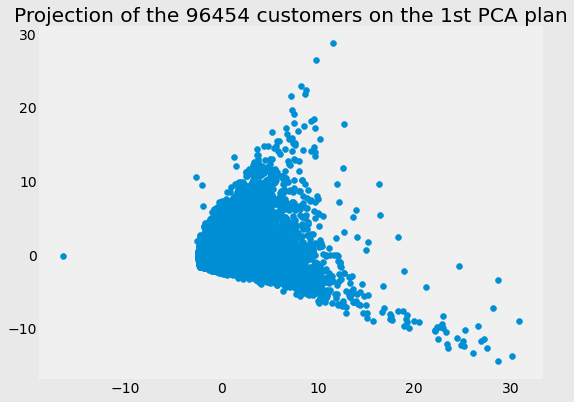

In [37]:
fig=plt.figure(figsize=[8,6])
fig.patch.set_facecolor('#E0E0E0')
fig.patch.set_alpha(0.7)
plt.title("Projection of the {} customers on the 1st PCA plan".format(data_pca.shape[0]))
plt.scatter(data=data_pca,x="pca 1",y="pca 2")
plt.grid()

In [49]:
pca = PCA(n_components=6)
principalComponents  = pca.fit_transform(Xs)

In [50]:
principalComponents

array([[-0.90269153, -0.9993054 ,  0.69696762, -1.35266836,  5.05164236,
         1.11482468],
       [ 0.16393527, -0.65412441,  0.28615244,  0.51855342,  0.06851785,
        -0.81677222],
       [-1.02810382,  0.26337393, -0.61276386, -0.73252264, -0.28631283,
        -0.48219331],
       ...,
       [ 2.43533353,  2.42589939,  0.73738902, -1.24739922, -0.39551439,
        -0.93619823],
       [ 1.82094435,  2.7274639 , -0.09524679, -0.867147  , -0.38427105,
         0.3206973 ],
       [-1.21203682,  0.03244382, -0.70691742, -0.01815884, -0.08961451,
        -0.6173501 ]])

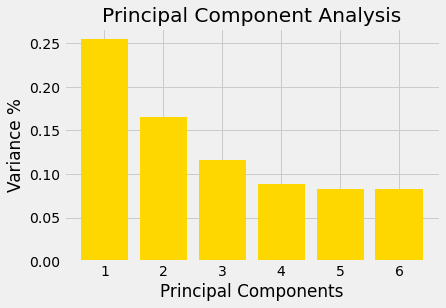

In [51]:
# Plotting the variances for each PC
plt.style.use("fivethirtyeight")
PC = range(1, pca.n_components_+1)
plt.bar(PC, pca.explained_variance_ratio_, color='gold')
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.title('Principal Component Analysis')
plt.xticks(PC)

# Putting components in a dataframe for later
PCA_components = pd.DataFrame(principalComponents)


In [52]:
pca.explained_variance_ratio_.sum()

0.7900721954802485

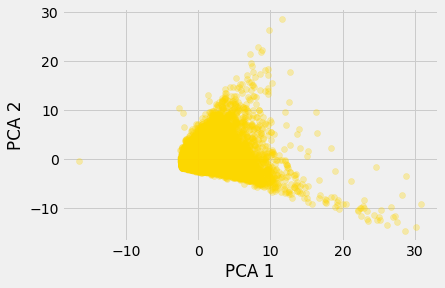

In [53]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.3, color='gold')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


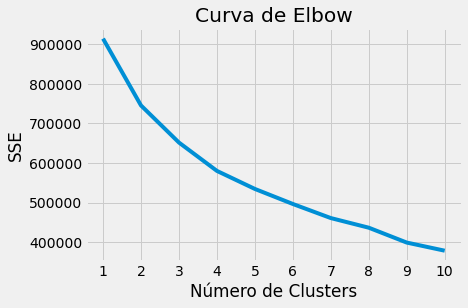

In [54]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42}
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(PCA_components)
    sse.append(kmeans.inertia_)

#plot:
    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Número de Clusters")
plt.ylabel("SSE")
plt.title('Curva de Elbow')
plt.show()
    


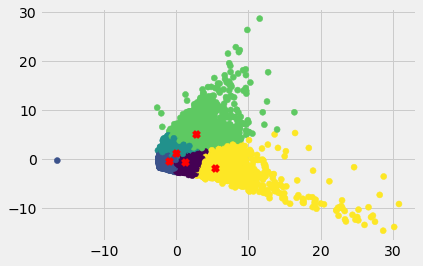

In [55]:
model = KMeans(n_clusters=5)
model.fit(PCA_components.iloc[:,:2])

labels = model.predict(PCA_components.iloc[:,:2])

#plot
plt.scatter(PCA_components[0], PCA_components[1], c=labels)
centers = np.array(model.cluster_centers_)
plt.scatter(centers[:,0], centers[:,1], marker="x", color='r')

plt.show()


In [56]:
kmeans = KMeans(n_clusters=5,
                init='random',
                n_init = 10,
                max_iter = 300,
                random_state = 42)
kmeans.fit(PCA_components)
y_kmeans = kmeans.predict(PCA_components)



In [57]:
df_with_clusters = df.copy()
df_with_clusters['cluster'] = y_kmeans
df_with_clusters.head()

,review_score,valor_frete_real,product_weight_g,product_photos_qty,payment_value,payment_sequential,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,diff_purchase_delivered,cluster
0,4,8.72,500.0,4.0,38.71,3.0,0.007431,2.373924,8.436574,15.544063,7.107488,8.436574,0
1,4,22.76,400.0,1.0,141.46,1.0,1.279745,1.742627,13.782037,19.137766,5.355729,13.782037,0
2,5,19.22,420.0,1.0,179.12,1.0,0.011505,0.216100,9.394213,26.639711,17.245498,9.394213,3
3,5,27.20,450.0,3.0,72.20,1.0,0.012419,3.758252,13.208750,26.188819,12.980069,13.208750,3
4,5,8.72,250.0,4.0,28.62,1.0,0.042940,0.936053,2.873877,12.112049,9.238171,2.873877,0


## Clusters EDA

In [58]:
conditions = [
    df_with_clusters['cluster'] == 0,
    df_with_clusters['cluster'] == 1,
    df_with_clusters['cluster'] == 2,
    df_with_clusters['cluster'] == 3,
    df_with_clusters['cluster'] == 4
]

values = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']

df_with_clusters['cluster_name'] = np.select(conditions,values)
df_with_clusters.head()

,review_score,valor_frete_real,product_weight_g,product_photos_qty,payment_value,payment_sequential,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,diff_purchase_delivered,cluster,cluster_name
0,4,8.72,500.0,4.0,38.71,3.0,0.007431,2.373924,8.436574,15.544063,7.107488,8.436574,0,Cluster 1
1,4,22.76,400.0,1.0,141.46,1.0,1.279745,1.742627,13.782037,19.137766,5.355729,13.782037,0,Cluster 1
2,5,19.22,420.0,1.0,179.12,1.0,0.011505,0.216100,9.394213,26.639711,17.245498,9.394213,3,Cluster 4
3,5,27.20,450.0,3.0,72.20,1.0,0.012419,3.758252,13.208750,26.188819,12.980069,13.208750,3,Cluster 4
4,5,8.72,250.0,4.0,28.62,1.0,0.042940,0.936053,2.873877,12.112049,9.238171,2.873877,0,Cluster 1


In [75]:
df_with_clusters['cluster'].value_counts().reset_index().sort_values(by = 'index')

,index,cluster
0,0,44111
3,1,7271
4,2,4141
1,3,30863
2,4,10068


In [60]:
cluster_1 = df_with_clusters[df_with_clusters['cluster'] == 0]
cluster_2 = df_with_clusters[df_with_clusters['cluster'] == 1]
cluster_3 = df_with_clusters[df_with_clusters['cluster'] == 2]
cluster_4 = df_with_clusters[df_with_clusters['cluster'] == 3]
cluster_5 = df_with_clusters[df_with_clusters['cluster'] == 4]

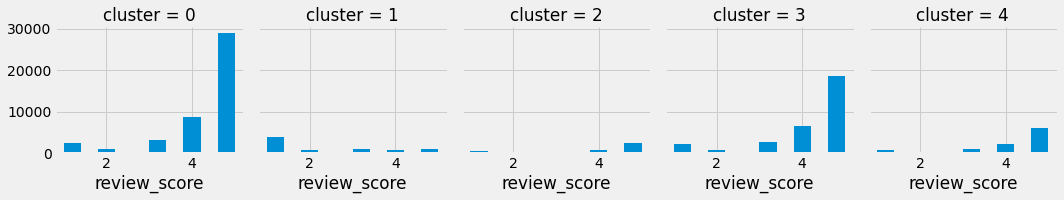

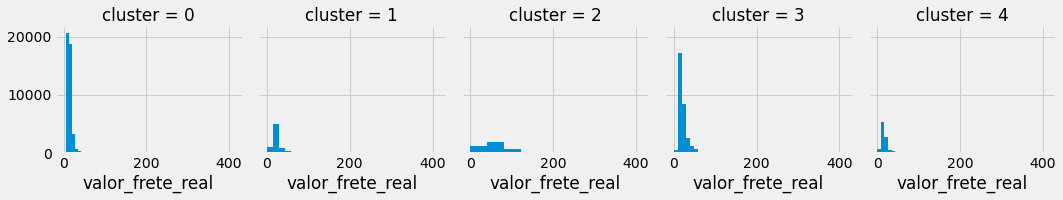

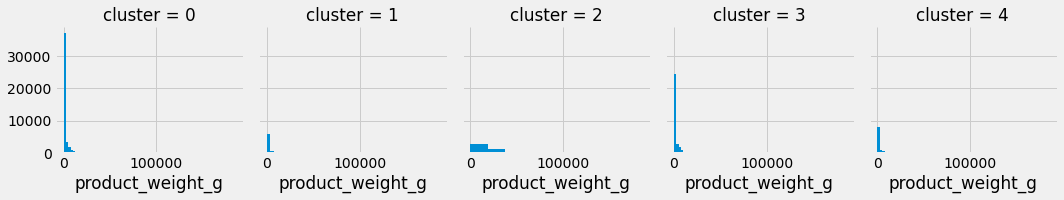

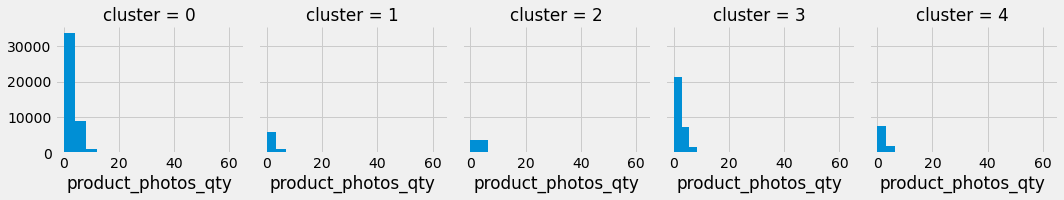

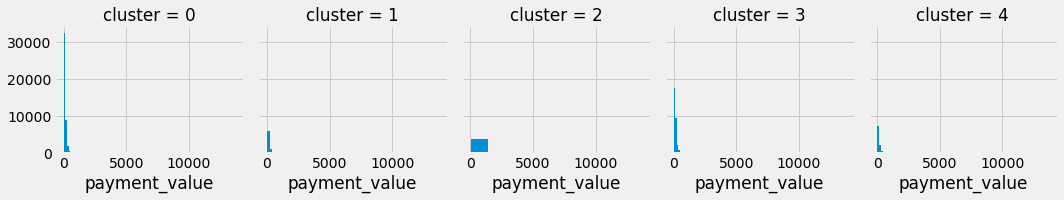

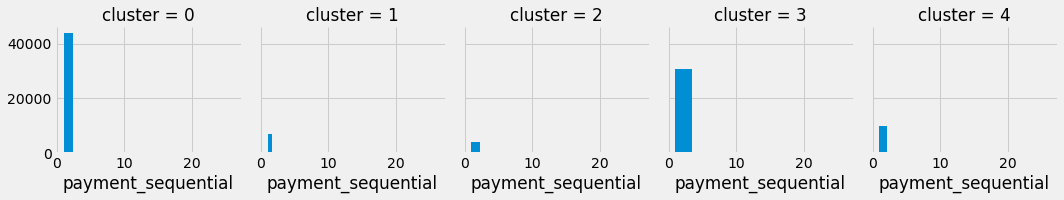

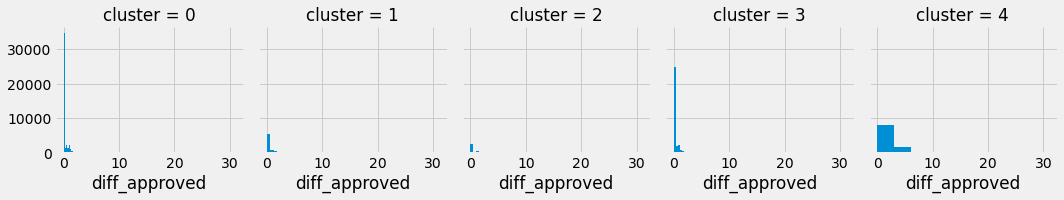

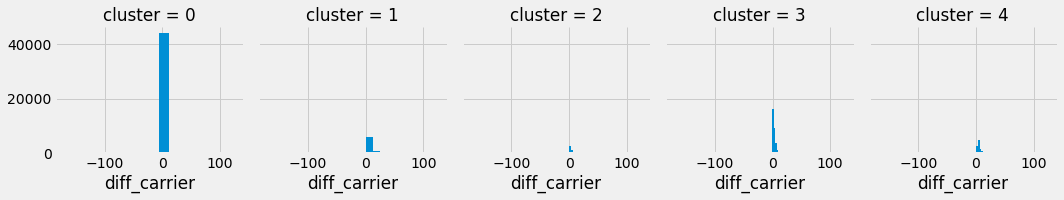

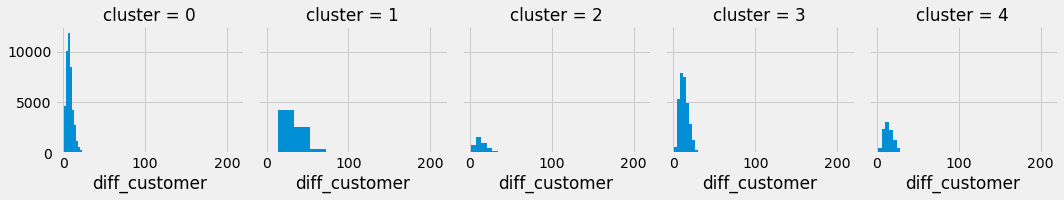

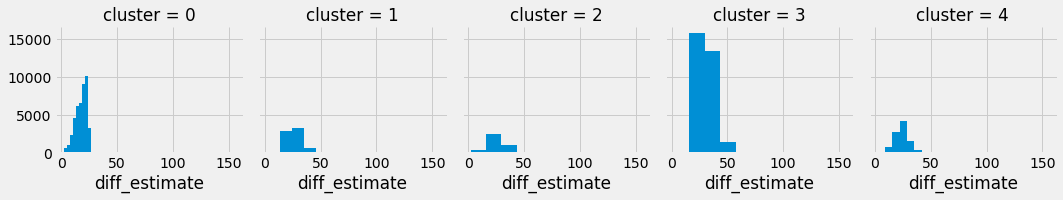

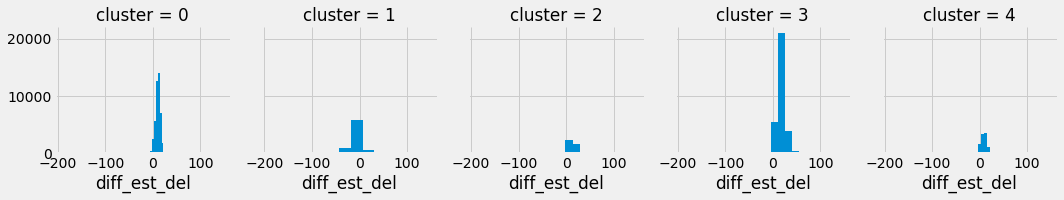

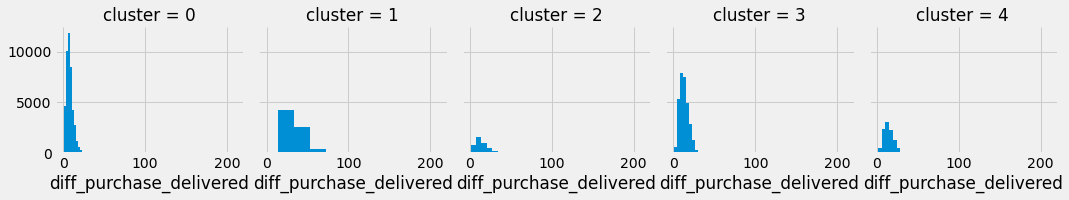

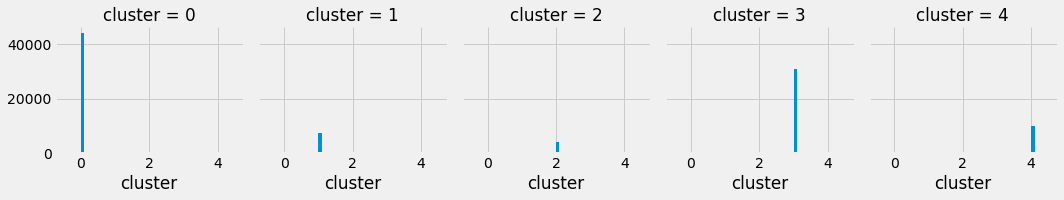

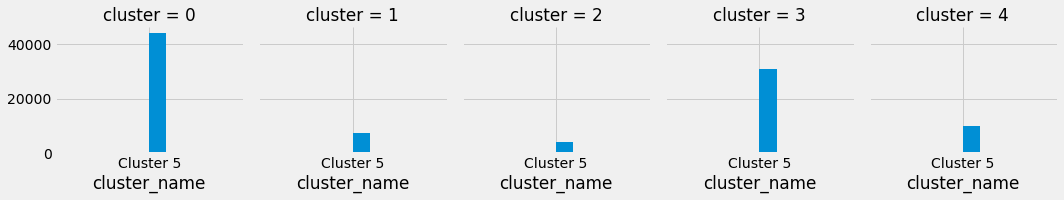

In [63]:
for c in df_with_clusters:
    grid = sns.FacetGrid(df_with_clusters, col='cluster')
    grid.map(plt.hist, c)

### Reviews

In [ ]:
rs_prop_1 = cluster_1['review_score'].value_counts(normalize=True).reset_index().rename(columns = {'review_score': 'percent',
                                                                                                   'index':'review_score'})
rs_prop_1['Cluster'] = 'Cluster 1'

rs_prop_2 = cluster_2['review_score'].value_counts(normalize=True).reset_index().rename(columns = {'review_score': 'percent',
                                                                                                   'index':'review_score'})
rs_prop_2['Cluster'] = 'Cluster 2'

rs_prop_3 = cluster_3['review_score'].value_counts(normalize=True).reset_index().rename(columns = {'review_score': 'percent',
                                                                                                   'index':'review_score'})
rs_prop_3['Cluster'] = 'Cluster 3'

rs_prop_4 = cluster_4['review_score'].value_counts(normalize=True).reset_index().rename(columns = {'review_score': 'percent',
                                                                                                   'index':'review_score'})
rs_prop_4['Cluster'] = 'Cluster 4'

rs_prop_5 = cluster_5['review_score'].value_counts(normalize=True).reset_index().rename(columns = {'review_score': 'percent',
                                                                                                   'index':'review_score'})
rs_prop_5['Cluster'] = 'Cluster 5'

rs_prop_6 = cluster_6['review_score'].value_counts(normalize=True).reset_index().rename(columns = {'review_score': 'percent',
                                                                                                   'index':'review_score'})
rs_prop_6['Cluster'] = 'Cluster 6'

rs_prop = pd.concat([rs_prop_1,rs_prop_2, rs_prop_3, rs_prop_4, rs_prop_5, rs_prop_6])
rs_prop

In [ ]:
sns.barplot(x='review_score',
            y = 'percent',
            hue = 'Cluster',
            data = rs_prop,
            palette = 'mako')
plt.show()

### Price

In [ ]:
ax = sns.boxplot(y = 'price',
                 x = 'cluster_name',
                 data = df_with_clusters,
                 palette = 'viridis',
                 order=['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6'])
plt.show()

In [ ]:
ax = sns.boxplot(y = 'freight_value',
            x = 'cluster_name',
            data = df_with_clusters,
            palette = 'mako',
            order=['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6'])
plt.show()

### Payment type

In [ ]:
pmt_type = df_with_clusters[['boleto','credit_card', 'debit_card', 'cluster_name']]
pmt_type.head()

In [ ]:
pmt_type.groupby('cluster_name').sum()

Não há diferença entre grupos em relação a tipo de pagamento.

### Região

In [ ]:
df_regiao = df_with_clusters[['customer_region_centro_oeste',
                              'customer_region_nordeste',
                              'customer_region_norte',
                              'customer_region_sudeste',
                              'customer_region_sul',
                              'cluster_name']]

In [ ]:
df_regiao.head()

In [ ]:
regiao_grouped = df_regiao.groupby('cluster_name').sum()
regiao_grouped

In [ ]:
regiao_grouped.idxmax(axis=1)

#### Capital

In [ ]:
capital_prop_1 = cluster_1['customer_capital'].value_counts(normalize=True).reset_index().rename(columns = {'customer_capital': 'percent',
                                                                                                   'index':'customer_capital'})
capital_prop_1['Cluster'] = 'Cluster 1'

capital_prop_2 = cluster_2['customer_capital'].value_counts(normalize=True).reset_index().rename(columns = {'customer_capital': 'percent',
                                                                                                   'index':'customer_capital'})
capital_prop_2['Cluster'] = 'Cluster 2'

capital_prop_3 = cluster_3['customer_capital'].value_counts(normalize=True).reset_index().rename(columns = {'customer_capital': 'percent',
                                                                                                   'index':'customer_capital'})
capital_prop_3['Cluster'] = 'Cluster 3'

capital_prop_4 = cluster_4['customer_capital'].value_counts(normalize=True).reset_index().rename(columns = {'customer_capital': 'percent',
                                                                                                   'index':'customer_capital'})
capital_prop_4['Cluster'] = 'Cluster 4'

capital_prop = pd.concat([capital_prop_1,capital_prop_2, capital_prop_3, capital_prop_4])
capital_prop

In [ ]:
#Plot capital

sns.barplot(x='customer_capital',
            y = 'percent',
            hue = 'Cluster',
            data = capital_prop,
            palette = 'viridis')
plt.show()

### Categoria de Produtos

In [ ]:
categ_prod = df_with_clusters[['product_category_name_bebes',
'product_category_name_beleza_saude',
'product_category_name_brinquedos',
'product_category_name_cama_mesa_banho',
'product_category_name_consoles_games',
'product_category_name_construcao_ferramentas_construcao',
'product_category_name_cool_stuff',
'product_category_name_eletrodomesticos',
'product_category_name_eletronicos',
'product_category_name_eletroportateis',
'product_category_name_esporte_lazer',
'product_category_name_fashion_bolsas_e_acessorios',
'product_category_name_ferramentas_jardim',
'product_category_name_informatica_acessorios',
'product_category_name_instrumentos_musicais',
'product_category_name_livros_interesse_geral',
'product_category_name_malas_acessorios',
'product_category_name_moveis_decoracao',
'product_category_name_moveis_escritorio',
'product_category_name_no info',
'product_category_name_papelaria',
'product_category_name_perfumaria',
'product_category_name_pet_shop',
'product_category_name_relogios_presentes',
'product_category_name_telefonia',
'product_category_name_utilidades_domesticas',
'cluster_name']]

In [ ]:
categ_prod.head()

In [ ]:
categ_grouped = categ_prod.groupby('cluster_name').sum()
categ_grouped

In [ ]:
categ_grouped.idxmax(axis=1)

In [ ]:
df_with_clusters.head()

### Tempo de entrega

In [ ]:
time_delivered = df_with_clusters[['diff_approved', 
                                   'diff_carrier',
                                   'diff_customer',
                                   'diff_estimate',
                                   'diff_est_del',
                                   'cluster_name']]

time_delivered.head()

In [ ]:
time_del_grouped = time_delivered.groupby('cluster_name').mean().reset_index()
time_del_grouped

In [ ]:
tidy_time_del_grouped = time_del_grouped.melt(id_vars='cluster_name').rename(columns=str.title)
tidy_time_del_grouped

In [ ]:
ax = fig, ax = plt.subplots(figsize=(15, 8))
ax = sns.barplot(x='Cluster_Name', 
                 y='Value', 
                 hue='Variable', 
                 data=tidy_time_del_grouped, 
                 ax=ax,
                 palette = 'mako',
                 order = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'CLuster 4', 'Cluster 5', 'Cluster 6'])
sns.despine(fig)